In [1]:
import os
import itertools
import random
import data_pipeline as pipeline
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
PROCESSED_DIR = "../data/processed"
IMG_HEIGHT = IMG_WIDTH = 224
NUM_CHANNELS = 3
NUM_CLASSES = 2
EPOCHS = 30
BATCH_SIZE = 128

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [4]:
metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
]

In [5]:
train_dir = os.path.join(PROCESSED_DIR, "train")
val_dir = os.path.join(PROCESSED_DIR, "val")
test_dir = os.path.join(PROCESSED_DIR, "test")

all_paths = pipeline.get_image_paths(PROCESSED_DIR)
train_paths = [path for path in all_paths if "/train/" in path]
mean, std = pipeline.calc_mean_std(train_paths)

# use generators from data_pipeline for training, validation, and testing
print("loading train/val/test generators from data_pipeline")
train_data_gen, val_data_gen, test_data_gen, test_data_gen_raw = pipeline.load_data(
    train_dir, val_dir, test_dir, mean, std
)

loading train/val/test generators from data_pipeline
creating train generator
Found 1600 images belonging to 2 classes.
creating validation generator
Found 400 images belonging to 2 classes.
creating test generator (normalized)
Found 200 images belonging to 2 classes.
creating test generator (raw)
Found 200 images belonging to 2 classes.


In [6]:
image_size = (IMG_HEIGHT, IMG_WIDTH)
input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

In [7]:
class_names = list(train_data_gen.class_indices.keys())
print(f"class names found: {class_names}")

class names found: ['COVID', 'NORMAL']


In [8]:
def build_model(input_shape):
    """
    build keras sequential model

    params
    ------
    input_shape: tuple
        shape of input images (height, width, channels)

    returns
    -------
    model: tf.keras.Model
        compiled keras model
    """
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=input_shape),
            # convolutional
            tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            # fully connected
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),  # random value
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.3),  # random value
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    return model

In [9]:
def train_model(model, train_data, val_data, epochs=EPOCHS):
    # compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=metrics,
    )
    # train the model
    history = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)
    return history

In [10]:
# build model
model = build_model(input_shape)

# print model summary
print("model architecture:")
model.summary()

model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,946,753 (49.39 MB)

 Trainable params: 12,946,753 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# train the model
history = train_model(model, train_data_gen, val_data_gen, EPOCHS)

/opt/anaconda3/envs/ml-2025/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 - 26s - 2s/step - accuracy: 0.5713 - loss: 0.8630 - precision: 0.5513 - recall: 0.7663 - val_accuracy: 0.5125 - val_loss: 0.7130 - val_precision: 0.5148 - val_recall: 0.4350
Epoch 2/30
13/13 - 24s - 2s/step - accuracy: 0.6981 - loss: 0.5913 - precision: 0.6931 - recall: 0.7113 - val_accuracy: 0.6125 - val_loss: 0.6641 - val_precision: 0.6166 - val_recall: 0.5950
Epoch 3/30
13/13 - 25s - 2s/step - accuracy: 0.7375 - loss: 0.5441 - precision: 0.7387 - recall: 0.7350 - val_accuracy: 0.6675 - val_loss: 0.6216 - val_precision: 0.6959 - val_recall: 0.5950
Epoch 4/30
13/13 - 23s - 2s/step - accuracy: 0.7475 - loss: 0.5121 - precision: 0.7494 - recall: 0.7437 - val_accuracy: 0.6675 - val_loss: 0.6106 - val_precision: 0.8602 - val_recall: 0.4000
Epoch 5/30
13/13 - 25s - 2s/step - accuracy: 0.7500 - loss: 0.5034 - precision: 0.7833 - recall: 0.6913 - val_accuracy: 0.7200 - val_loss: 0.5931 - val_precision: 0.7444 - val_recall: 0.6700
Epoch 6/30
13/13 - 25s - 2s/step - accuracy: 

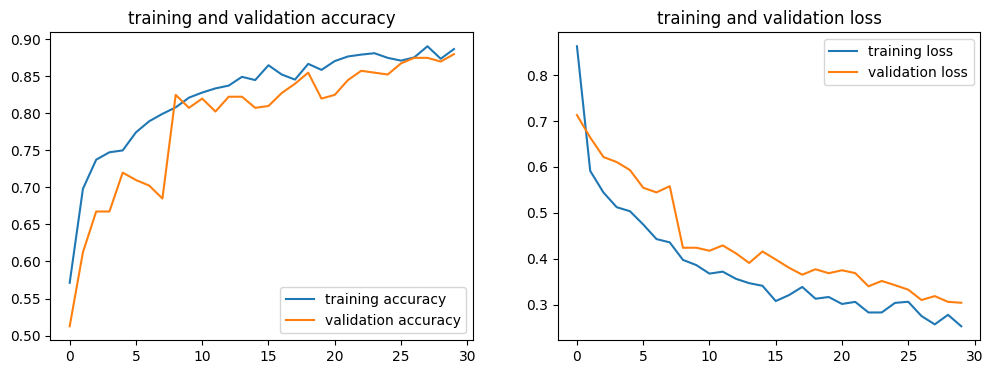

In [12]:
# plot training history
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="training accuracy")
plt.plot(epochs_range, val_acc, label="validation accuracy")
plt.legend(loc="lower right")
plt.title("training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="training loss")
plt.plot(epochs_range, val_loss, label="validation loss")
plt.legend(loc="upper right")
plt.title("training and validation loss")
plt.show()

In [13]:
# evaluate the model on the validation set after training
print("\nevaluating model on validation data after training")
results = model.evaluate(val_data_gen, verbose=1)
print(f"final validation loss: {results[0]}")
print(f"final validation accuracy: {results[1]}")
print(f"final validation precision: {results[2]}")
print(f"final validation recall: {results[3]}")


evaluating model on validation data after training
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.8700 - loss: 0.3069 - precision: 0.6495 - recall: 0.7170     
final validation loss: 0.30384504795074463
final validation accuracy: 0.8799999952316284
final validation precision: 0.8689320683479309
final validation recall: 0.8949999809265137


# with hyperparam tuning

In [14]:
def build_model(input_shape, filters_conv1, units_dense1, dropout_rate):
    """
    build keras sequential model

    params
    ------
    input_shape: tuple
        shape of input images (height, width, channels)
    filters_conv1: int
        number of filters in the first convolutional layer
    units_dense1: int
        number of units in the first dense layer
    dropout_rate: float
        dropout rate for dropout layers

    returns
    -------
    model: tf.keras.Model
        keras model (not compiled)
    """
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=input_shape),
            # convolutional
            tf.keras.layers.Conv2D(
                filters_conv1, (3, 3), activation="relu", padding="same"
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            # fully connected
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units_dense1, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    return model


In [15]:
# define search space
learning_rates = [1e-3, 1e-4, 1e-5]
filters_conv1_list = [16, 32, 64]
units_dense1_list = [64, 128, 256]
dropout_rates = [0.2, 0.3, 0.4, 0.5]

In [16]:
# create all possible combinations (full grid)
param_grid = list(
    itertools.product(
        learning_rates, filters_conv1_list, units_dense1_list, dropout_rates
    )
)

In [17]:
# define number of combinations to randomly sample
num_combinations_to_test = 10

# randomly sample combinations
sampled_params = random.sample(param_grid, num_combinations_to_test)
print(
    f"randomly sampling {num_combinations_to_test} combinations from {len(param_grid)} total."
)

randomly sampling 10 combinations from 108 total.


In [18]:
# store results
results_list = []

In [19]:
# early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

In [20]:
print("starting hyperparameter tuning")

for lr, filters1, units1, dr in sampled_params:
    print(
        f"testing: lr={lr}, filters_conv1={filters1}, units_dense1={units1}, dropout_rate={dr}"
    )

    # build model
    input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
    model = build_model(
        input_shape,
        filters_conv1=filters1,
        units_dense1=units1,
        dropout_rate=dr,
    )

    # compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

    # train the model
    history = model.fit(
        train_data_gen,
        epochs=EPOCHS,
        validation_data=val_data_gen,
        callbacks=[early_stopping],
        verbose=2,
    )

    # evaluate the model on the validation set using best weights from early stopping
    print("evaluating best model from this run")
    eval_results = model.evaluate(val_data_gen, verbose=1)

    run_results = {
        "learning_rate": lr,
        "filters_conv1": filters1,
        "units_dense1": units1,
        "dropout_rate": dr,
        "val_loss": eval_results[0],
        "val_accuracy": eval_results[1],
        "val_precision": eval_results[2],
        "val_recall": eval_results[3],
        "epochs_trained": len(history.epoch),
    }
    results_list.append(run_results)

print("hyperparameter tuning finished.")

starting hyperparameter tuning
testing: lr=0.001, filters_conv1=16, units_dense1=64, dropout_rate=0.2
Epoch 1/30
13/13 - 19s - 1s/step - accuracy: 0.6310 - loss: 1.1767 - precision: 0.6035 - recall: 0.7640 - val_accuracy: 0.5625 - val_loss: 0.6716 - val_precision: 0.5415 - val_recall: 0.8150
Epoch 2/30
13/13 - 19s - 1s/step - accuracy: 0.6981 - loss: 0.5868 - precision: 0.6736 - recall: 0.7688 - val_accuracy: 0.6475 - val_loss: 0.6733 - val_precision: 0.7521 - val_recall: 0.4400
Epoch 3/30
13/13 - 18s - 1s/step - accuracy: 0.7387 - loss: 0.5293 - precision: 0.7520 - recall: 0.7125 - val_accuracy: 0.6175 - val_loss: 0.6433 - val_precision: 0.6009 - val_recall: 0.7000
Epoch 4/30
13/13 - 18s - 1s/step - accuracy: 0.7538 - loss: 0.5182 - precision: 0.7699 - recall: 0.7237 - val_accuracy: 0.7000 - val_loss: 0.5993 - val_precision: 0.7410 - val_recall: 0.6150
Epoch 5/30
13/13 - 18s - 1s/step - accuracy: 0.7719 - loss: 0.4981 - precision: 0.7675 - recall: 0.7800 - val_accuracy: 0.7050 - val_l

In [21]:
# convert results to dataframe
results_df = pd.DataFrame(results_list)

# sort by validation accuracy (descending)
results_df = results_df.sort_values(by="val_accuracy", ascending=False)

# print results
print("\ntuning results summary:")
print(results_df)

# save results to csv
results_filename = "../results/hyperparameter_tuning_results_random_search.csv"
results_df.to_csv(results_filename, index=False)
print(f"\nresults saved to {results_filename}")


tuning results summary:
   learning_rate  filters_conv1  units_dense1  dropout_rate  val_loss  \
6        0.00100             32           256           0.2  0.306606   
5        0.00100             64           256           0.3  0.298156   
8        0.00010             32           256           0.2  0.343528   
0        0.00100             16            64           0.2  0.314409   
3        0.00100             32           128           0.2  0.335180   
9        0.00010             64           256           0.4  0.378565   
1        0.00010             16           128           0.4  0.406113   
4        0.00001             16           256           0.3  0.468071   
7        0.00001             32           256           0.4  0.492562   
2        0.00001             64            64           0.4  0.596940   

   val_accuracy  val_precision  val_recall  epochs_trained  
6        0.8775       0.868293       0.890              30  
5        0.8725       0.911602       0.825       

In [22]:
# concatenate train and val data
X_all = []
y_all = []

train_data_gen.reset()
val_data_gen.reset()

for batch_x, batch_y in train_data_gen:
    X_all.append(batch_x)
    y_all.append(batch_y)
    if len(X_all) * BATCH_SIZE >= train_data_gen.samples:
        break

for batch_x, batch_y in val_data_gen:
    X_all.append(batch_x)
    y_all.append(batch_y)
    if len(X_all) * BATCH_SIZE >= val_data_gen.samples + train_data_gen.samples:
        break

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)

# create dataset
train_val_ds = (
    tf.data.Dataset.from_tensor_slices((X_all, y_all))
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
print("\nretraining the best model on the combined train+validation data")
best_params = results_df.iloc[0]
best_lr = best_params["learning_rate"]
best_filters_conv1 = int(
    best_params["filters_conv1"]
)  # cast to int, wasn't working before
best_units_dense1 = int(
    best_params["units_dense1"]
)  # cast to int, wasn't working before
best_dropout_rate = best_params["dropout_rate"]
print(
    f"best hyperparameters found: lr={best_lr}, filters_conv1={best_filters_conv1}, units_dense1={best_units_dense1}, dropout_rate={best_dropout_rate}"
)


retraining the best model on the combined train+validation data
best hyperparameters found: lr=0.001, filters_conv1=32, units_dense1=256, dropout_rate=0.2


In [24]:
# build the best model
final_model = build_model(
    input_shape,
    filters_conv1=best_filters_conv1,
    units_dense1=best_units_dense1,
    dropout_rate=best_dropout_rate,
)

# compile the best model
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
final_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

# define steps per epoch
steps_per_epoch = (train_data_gen.samples + val_data_gen.samples) // BATCH_SIZE

# train the best model on the combined train+val data
final_history = final_model.fit(
    train_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    verbose=2,
)

Epoch 1/30
15/15 - 27s - 2s/step - accuracy: 0.5707 - loss: 1.5957 - precision: 0.5830 - recall: 0.4757
Epoch 2/30
15/15 - 1s - 55ms/step - accuracy: 0.5469 - loss: 0.6493 - precision: 0.5246 - recall: 1.0000
Epoch 3/30


/opt/anaconda3/envs/ml-2025/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 - 25s - 2s/step - accuracy: 0.6307 - loss: 0.6330 - precision: 0.6019 - recall: 0.7518
Epoch 4/30
15/15 - 1s - 55ms/step - accuracy: 0.6250 - loss: 0.5886 - precision: 0.6098 - recall: 0.7576
Epoch 5/30
15/15 - 25s - 2s/step - accuracy: 0.7141 - loss: 0.5754 - precision: 0.7040 - recall: 0.7284
Epoch 6/30
15/15 - 1s - 70ms/step - accuracy: 0.7031 - loss: 0.5965 - precision: 0.7586 - recall: 0.6471
Epoch 7/30
15/15 - 27s - 2s/step - accuracy: 0.7505 - loss: 0.5264 - precision: 0.7714 - recall: 0.7075
Epoch 8/30
15/15 - 1s - 57ms/step - accuracy: 0.7812 - loss: 0.5192 - precision: 0.7353 - recall: 0.8333
Epoch 9/30
15/15 - 25s - 2s/step - accuracy: 0.7807 - loss: 0.4676 - precision: 0.7984 - recall: 0.7474
Epoch 10/30
15/15 - 1s - 62ms/step - accuracy: 0.7656 - loss: 0.4210 - precision: 0.7586 - recall: 0.7333
Epoch 11/30
15/15 - 25s - 2s/step - accuracy: 0.8411 - loss: 0.3809 - precision: 0.8575 - recall: 0.8151
Epoch 12/30
15/15 - 1s - 56ms/step - accuracy: 0.8125 - loss: 0.4149 


plotting final training history


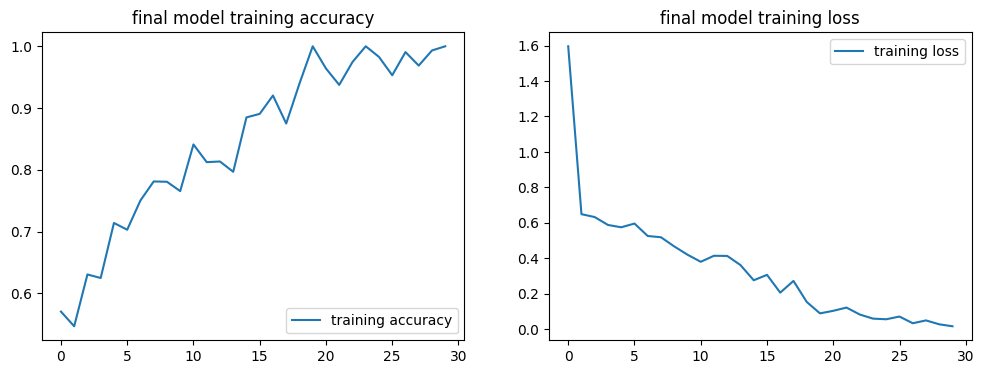

In [25]:
print("\nplotting final training history")
final_acc = final_history.history["accuracy"]
final_loss = final_history.history["loss"]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, final_acc, label="training accuracy")
plt.legend(loc="lower right")
plt.title("final model training accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, final_loss, label="training loss")
plt.legend(loc="upper right")
plt.title("final model training loss")
plt.show()

In [26]:
model_save_path = "../models/baseline_model.keras"
print(f"\nsaving final model to {model_save_path}")
final_model.save(model_save_path)

print("loading model back")
loaded_model = tf.keras.models.load_model(model_save_path)
print("model loaded successfully")


saving final model to ../models/baseline_model.keras
loading model back
model loaded successfully


In [27]:
print("\nevaluating loaded model on test data")
test_results = loaded_model.evaluate(test_data_gen, verbose=1)
print(f"test loss: {test_results[0]}")
print(f"test accuracy: {test_results[1]}")
print(f"test precision: {test_results[2]}")
print(f"test recall: {test_results[3]}")


evaluating loaded model on test data


/opt/anaconda3/envs/ml-2025/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.8772 - loss: 0.5137 - precision: 0.7614 - recall: 0.9614
test loss: 0.4800443947315216
test accuracy: 0.8899999856948853
test precision: 0.8421052694320679
test recall: 0.9599999785423279



generating confusion matrix
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


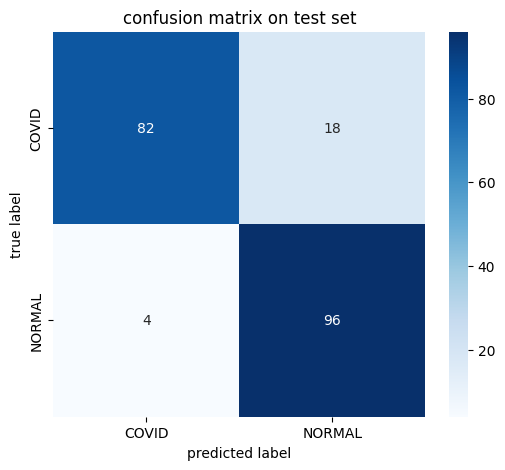

In [28]:
print("\ngenerating confusion matrix")
# get predictions (probabilities)
y_pred_prob = loaded_model.predict(test_data_gen)
# convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
# get true labels
y_true = test_data_gen.classes
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.title("confusion matrix on test set")
plt.show()


plotting sample test images with predictions
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


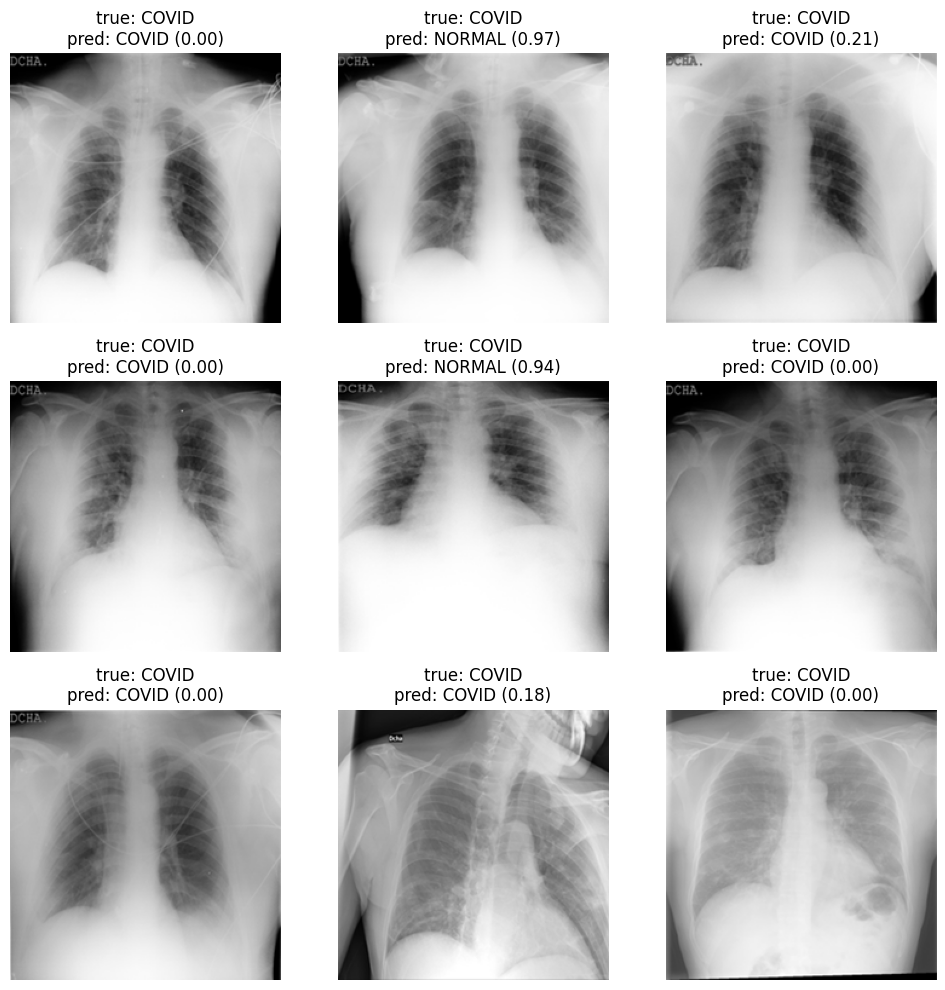

In [29]:
print("\nplotting sample test images with predictions")
# get a batch of raw (unnormalized) images and labels
images_raw, labels_raw = next(iter(test_data_gen_raw))
# get predictions for this batch using the normalized data generator
# important: ensure we use the *same batch* for predictions
# we need to reset the generator to be sure we get the same batch
test_data_gen.reset()
images_norm, _ = next(iter(test_data_gen))  # get normalized images for prediction
batch_pred_prob = loaded_model.predict(images_norm)
batch_pred = (batch_pred_prob > 0.5).astype(int).flatten()

plt.figure(figsize=(10, 10))
for i in range(9):  # display 9 samples
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_raw[i].astype("uint8"))  # display raw image
    true_label = class_names[int(labels_raw[i])]  # cast to int
    pred_label = class_names[batch_pred[i]]
    prob = batch_pred_prob[i][0]
    plt.title(f"true: {true_label}\npred: {pred_label} ({prob:.2f})")
    plt.axis("off")
plt.tight_layout()
plt.show()